Elijah Reeb EE399 Homework 5 
Github link - 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

In [82]:
def lorenz_solve(rho):

#     rcParams.update({'font.size': 18})
#     plt.rcParams['figure.figsize'] = [12, 12]

    dt = 0.01
    T = 8
    t = np.arange(0,T+dt,dt)
    beta = 8/3
    sigma = 10
    rho = rho


    lor_input = np.zeros((100*(len(t)-1),3))
    lor_output = np.zeros_like(lor_input)

#     fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
#     title = 'Lorenz Equation Output for rho =  {} '.format(rho)
#     fig.suptitle(title, fontsize = 20)


    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((100, 3))

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                      for x0_j in x0])

    for j in range(100):
        lor_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        lor_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
        x, y, z = x_t[j,:,:].T
    
#         ax.plot(x, y, z,linewidth=1)
#         ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
#     ax.view_init(18, -113)
#     plt.show()

    return lor_input, lor_output
 

### Part 1
Train a NN to advance the solution from t to t + ∆t for ρ = 10, 28 and 40. Now see how well
your NN works for future state prediction for ρ = 17 and ρ = 35

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [97]:
# Define activation functions
def logsig(x):
    return 1 / (1 + torch.exp(-x))

def radbas(x):
    return torch.exp(-torch.pow(x, 2))

def purelin(x):
    return x

# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(in_features=3, out_features=40)
        self.fc2 = nn.Linear(in_features=40, out_features=30)
        self.fc3 = nn.Linear(in_features=30, out_features=10)
        self.fc4 = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x = logsig(self.fc1(x))
        x = radbas(self.fc2(x))
        x = radbas(self.fc3(x))
        x = purelin(self.fc4(x))
        return x

# Create model instance
model = MyModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=.4)

In [83]:
# Create training data for rho = 10, 28, and 40
# this is done by running the function above to generate the lorenz data

rho10_inp, rho10_out = lorenz_solve(10)
rho28_inp, rho28_out = lorenz_solve(28)
rho40_inp, rho40_out = lorenz_solve(40)
print(np.shape(rho10_inp))
print(np.shape(rho10_out))

# compile 3 datasets into 1 dataset for training
train_data = np.concatenate((rho10_inp, rho28_inp, rho40_inp), axis=0)
print(np.shape(train_data))

train_labels = np.concatenate((rho10_out, rho28_out, rho40_out), axis=0)
print(np.shape(train_labels))
# Convert numpy arrays to PyTorch tensors

#nn_input = torch.from_numpy(nn_input).float()
#nn_output = torch.from_numpy(nn_output).float()

nn_input = torch.tensor(train_data, dtype=torch.float32)
nn_output = torch.tensor(train_labels, dtype =torch.float32)

(80000, 3)
(80000, 3)
(240000, 3)
(240000, 3)


Epoch 1, loss=27.9399
Epoch 2, loss=4.4731
Epoch 3, loss=1.5415
Epoch 4, loss=-1.5220
Epoch 5, loss=-6.9720
Epoch 6, loss=5.6518
Epoch 7, loss=-0.6197
Epoch 8, loss=-4.0667
Epoch 9, loss=-36.5496
Epoch 10, loss=-55.0506
Epoch 11, loss=-67.1652
Epoch 12, loss=-89.2818
Epoch 13, loss=-118.3129
Epoch 14, loss=-141.3312
Epoch 15, loss=-166.8261
Epoch 16, loss=-189.9105
Epoch 17, loss=-213.7362
Epoch 18, loss=-237.2238
Epoch 19, loss=-260.7267
Epoch 20, loss=-284.1354
Epoch 21, loss=-307.5229
Epoch 22, loss=-330.8727
Epoch 23, loss=-354.2091
Epoch 24, loss=-377.5281
Epoch 25, loss=-400.8245
Epoch 26, loss=-424.0425
Epoch 27, loss=-447.0103
Epoch 28, loss=-468.7850
Epoch 29, loss=-491.2312
Epoch 30, loss=-508.2603


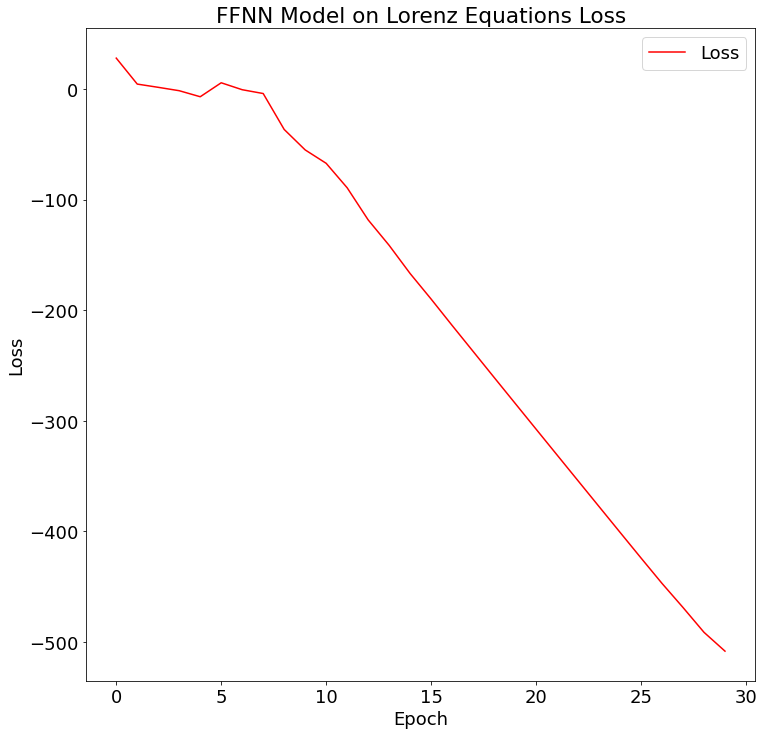

In [98]:
# Train the model
num_epochs = 30

loss_graph = np.zeros(int(num_epochs))

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(nn_input)
    loss = criterion(outputs, nn_output)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, loss={loss.item():.4f}")
    loss_graph[epoch] = loss.item()

eps = np.arange(num_epochs)
plt.plot(eps, loss_graph, 'r', label = 'Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FFNN Model on Lorenz Equations Loss')
plt.legend()
plt.show()

In [100]:
# Test the network on rho of 17 and 35

rho17_inp, rho17_out = lorenz_solve(17)
rho35_inp, rho35_out = lorenz_solve(35)

test17_inp = torch.tensor(rho17_inp, dtype=torch.float32)
test17_out = torch.tensor(rho17_out, dtype =torch.float32)

# Evaluate the model on the test data
with torch.no_grad():
    y_pred = model(test17_inp)
    loss = nn.MSELoss()(y_pred, test17_out)

# Compute the accuracy
acc = 1 - loss.item()

# Print the accuracy
print("Test accuracy on rho = 17:", acc)

# Evaluate on rho = 35

test35_inp = torch.tensor(rho35_inp, dtype=torch.float32)
test35_out = torch.tensor(rho35_out, dtype =torch.float32)

# Evaluate the model on the test data
with torch.no_grad():
    y_pred = model(test35_inp)
    loss = nn.MSELoss()(y_pred, test35_out)

# Compute the accuracy
acc = 1 - loss.item()

# Print the accuracy
print("Test accuracy on rho = 35:", acc)



Test accuracy on rho = 17: -516.5416870117188
Test accuracy on rho = 35: -505.4313659667969


In [22]:
outputs.shape
nn_output.shape

torch.Size([80000, 3])

### Part 2
Compare feed-forward, LSTM, RNN and Echo State Networks for forecasting the dynamics.

In [102]:
# Now to set up LSTM Model for this data

import torch
import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Initialize the model
input_size = 3
hidden_size = 50
num_layers = 1
output_size = 3
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Train model 

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    running_loss = 0.0
    # Get the inputs and labels
    inputs = nn_input
    labels = nn_output

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
    if epoch % 100 == 99:
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

# Evaluate the model on the test data
with torch.no_grad():
    y_pred = model(X_test)
    loss = nn.MSELoss()(y_pred, y_test)

# Compute the accuracy
acc = 1 - loss.item()

# Print the accuracy
print("Test accuracy:", acc)


IndexError: too many indices for tensor of dimension 2

In [ ]:
# Now to set up RNN Model for this data

In [ ]:
# Now to set up Echo State Network for this data